<a href="https://colab.research.google.com/github/cerapcapiq/radio_app1/blob/main/handCXR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow version: 2.18.0
Data directory exists: True
Contents: ['AbdomenCT', 'CXR', 'ChestCT', 'BreastMRI', 'README.md', 'Hand', 'HeadCT']
Total images collected: 20000


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,826 (3.14 MB)

 Trainable params: 821,826 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 93s 183ms/step - accuracy: 0.9762 - loss: 0.0643 - val_accuracy: 0.9965 - val_loss: 0.0097
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9980 - val_loss: 0.0050
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 168ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9977 - val_loss: 0.0042
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 165ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.9983 - val_loss: 0.0035
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 166ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9985 - val_loss: 0.0040
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.9987 - loss: 0.0039
Test accuracy: 0.998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


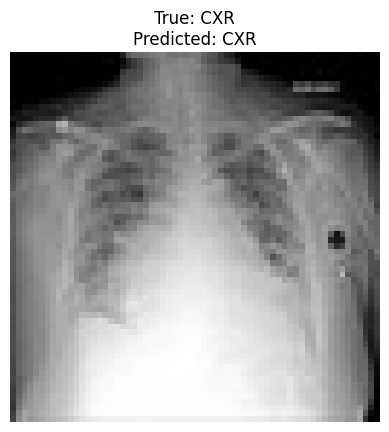

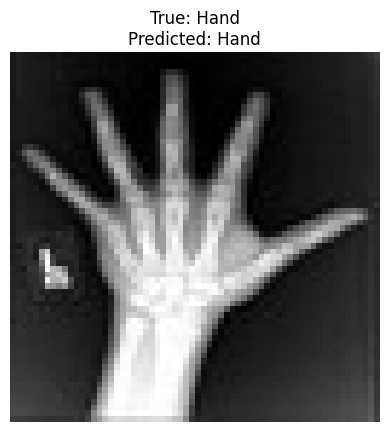

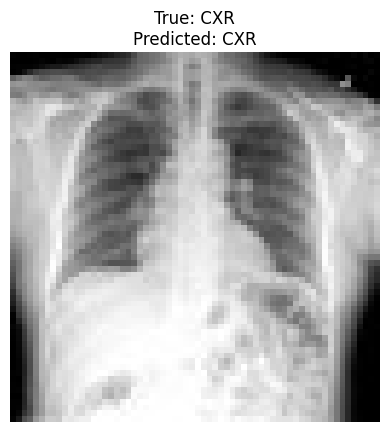

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import zipfile
import urllib.request
import tarfile

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Download MedNIST dataset (small subset with X-ray and MRI)

data_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
data_dir = pathlib.Path("MedNIST")

if not data_dir.exists():
    # Download the tar.gz file
    tar_path, _ = urllib.request.urlretrieve(data_url, "MedNIST.tar.gz")
    # Extract it
    with tarfile.open("MedNIST.tar.gz", "r:gz") as tar_ref:
        tar_ref.extractall()


# Check directory structure
print(f"Data directory exists: {data_dir.exists()}")
print(f"Contents: {os.listdir(data_dir)}")

# Focus on 'ChestCT' (MRI) and 'ChestXRay' (X-ray) folders
classes = ['CXR', 'Hand']
image_paths = []
labels = []

for label, class_name in enumerate(classes):
    class_dir = data_dir / class_name
    for img_file in os.listdir(class_dir):
        image_paths.append(str(class_dir / img_file))
        labels.append(label)

print(f"Total images collected: {len(image_paths)}")

# Shuffle data
from sklearn.utils import shuffle
image_paths, labels = shuffle(image_paths, labels, random_state=42)

# Load and preprocess images
IMG_SIZE = 64

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)  # grayscale
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0
    return img

# Create TensorFlow dataset
AUTOTUNE = tf.data.AUTOTUNE
path_ds = tf.data.Dataset.from_tensor_slices(image_paths)
image_ds = path_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(labels)
dataset = tf.data.Dataset.zip((image_ds, label_ds))

# Split dataset: 80% train, 20% test
dataset_size = len(image_paths)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = dataset.take(train_size).batch(32).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = dataset.skip(train_size).batch(32).cache().prefetch(buffer_size=AUTOTUNE)

# Build simple CNN model
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train model
history = model.fit(train_ds, epochs=5, validation_data=test_ds)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

# Save the model
model.save("mednist_cnn_model.keras")

# Test prediction example
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    for i in range(3):
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        plt.title(f"True: {classes[labels[i]]}\nPredicted: {classes[np.argmax(preds[i])]}")
        plt.axis('off')
        plt.show()



Prediction probabilities: [9.9999917e-01 8.7102507e-07]


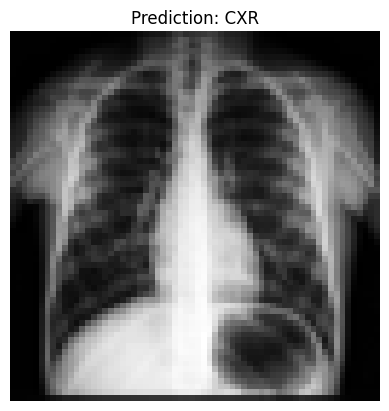

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 1. Define your class labels
classes = ['CXR', 'Hand']  # <- adjust if different

# 2. Load image from a URL (replace with your own)
url = "https://www.e7health.com/files/blogs/chest-x-ray-29.jpg"  # Example X-ray
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale

# 3. Preprocess image to (64, 64, 1), normalized
img = img.resize((64, 64))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=(0, -1))  # Shape: (1, 64, 64, 1)

# 4. Load your saved model
model = tf.keras.models.load_model("mednist_cnn_model.keras")  # or .h5 if you used that format

# 5. Predict
prediction = model.predict(img_array, verbose=0)
predicted_class = classes[np.argmax(prediction)]

# 6. Show result
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title(f"Prediction: {predicted_class}")
print("Prediction probabilities:", prediction[0])

plt.axis('off')
plt.show()


Prediction probabilities: [9.9999917e-01 8.7102507e-07]


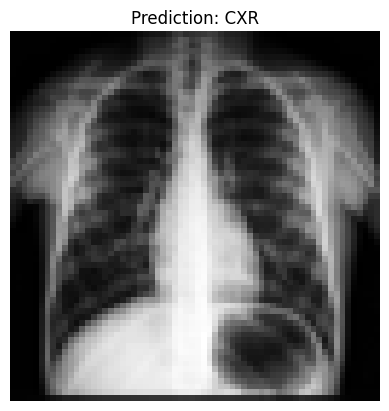

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 1. Define your class labels
classes = ['CXR', 'Hand']  # <- adjust if different

# 2. Load image from a URL (replace with your own)
url = "https://www.e7health.com/files/blogs/chest-x-ray-29.jpg"  # Example X-ray
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale

# 3. Preprocess image to (64, 64, 1), normalized
img = img.resize((64, 64))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=(0, -1))  # Shape: (1, 64, 64, 1)

# 4. Load your saved model
model = tf.keras.models.load_model("mednist_cnn_model.keras")  # or .h5 if you used that format

# 5. Predict
prediction = model.predict(img_array, verbose=0)
predicted_class = classes[np.argmax(prediction)]

# 6. Show result
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title(f"Prediction: {predicted_class}")
print("Prediction probabilities:", prediction[0])

plt.axis('off')
plt.show()


Prediction probabilities: [0.14234921 0.8576507 ]


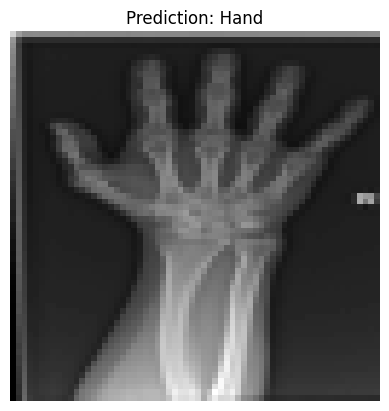

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO

# 1. Define your class labels
classes = ['CXR', 'Hand']  # <- adjust if different

# 2. Load image from a URL (replace with your own)
url = "https://prod-images-static.radiopaedia.org/images/25366514/7528853b7844ad16bee13ffb111b8c_big_gallery.jpeg"  # Example X-ray
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')  # Convert to grayscale

# 3. Preprocess image to (64, 64, 1), normalized
img = img.resize((64, 64))
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=(0, -1))  # Shape: (1, 64, 64, 1)

# 4. Load your saved model
model = tf.keras.models.load_model("mednist_cnn_model.keras")  # or .h5 if you used that format

# 5. Predict
prediction = model.predict(img_array, verbose=0)
predicted_class = classes[np.argmax(prediction)]

# 6. Show result
plt.imshow(img_array.squeeze(), cmap='gray')
plt.title(f"Prediction: {predicted_class}")
print("Prediction probabilities:", prediction[0])

plt.axis('off')
plt.show()

